# Imports + pipeline call

In [2]:
import matplotlib.pyplot as plt

from constants.taxi_c import GeoBounds as gb
from pipelines.taxi_pipeline import build_taxi_dataset

/Users/nnord/uni/projects/taxi_trip/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
taxi_df = build_taxi_dataset(save_csv=True)

# EDA Hist / describe

- 1458644 rows
- 11 columns
- object: id, pickup_datetime, dropoff_datetime, store_and_fwd_flag
- int64: vendor_id, passenger_count, trip_duration
- float64: pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
- no missing values/categories
- no NaNs
- id can be used for unique ID
- two unique vendors seems to be all right
- ten unique passengers
- two unique store_and_fwd_flag matches with description
- no duplicated rows

In [4]:
taxi_df.describe(include='object')

,id,store_and_fwd_flag
count,1458644,1458644
unique,1458644,2
top,id2875421,N
freq,1,1450599


## vendor_id

In [5]:
taxi_df['vendor_id'].value_counts()

vendor_id
2    780302
1    678342
Name: count, dtype: int64

In [6]:
taxi_df['vendor_id'].isna().sum()

np.int64(0)

- Only two unique values: 1 and 2.
- Frequencies are relatively balanced.
- No missing values or anomalies detected.

##  pickup_datetime & dropoff_datetime

In [7]:
# Number of missing values
print("Missing pickup_datetime:", taxi_df['pickup_datetime'].isna().sum())
print("Missing dropoff_datetime:", taxi_df['dropoff_datetime'].isna().sum())

Missing pickup_datetime: 0
Missing dropoff_datetime: 0


In [8]:
# Negative or unrealistic trip durations
invalid_times = (taxi_df['dropoff_datetime'] < taxi_df['pickup_datetime'])
print("Trips with negative duration:", invalid_times.sum())

Trips with negative duration: 0


- no negative durations

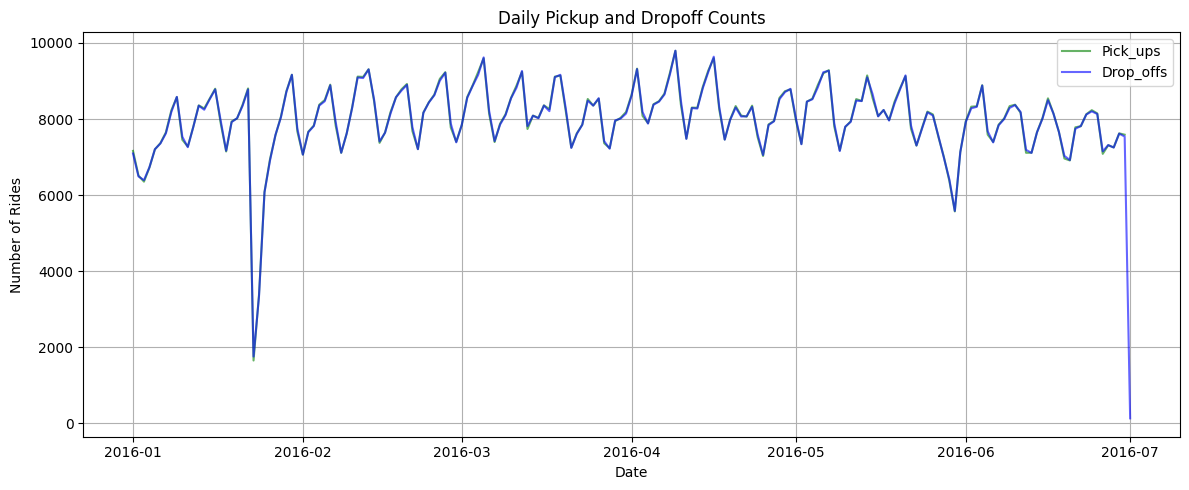

In [9]:
pickup_counts = taxi_df['pickup_datetime'].dt.date.value_counts().sort_index()
dropoff_counts = taxi_df['dropoff_datetime'].dt.date.value_counts().sort_index()

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
pickup_counts.plot(ax=ax, label="Pick_ups", color='green', alpha=0.6)
dropoff_counts.plot(ax=ax, label="Drop_offs", color='blue', alpha=0.6)

ax.set_title("Daily Pickup and Dropoff Counts")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Rides")
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- aligns with expected rush hour effects

##  passenger_count

In [10]:
print(taxi_df['passenger_count'].value_counts().sort_index())

passenger_count
1    1033600
2     210318
3      59896
4      28404
5      78088
6      48338
Name: count, dtype: int64


- 60 with passenger count 0
- 5 with passenger count > 6

<Axes: xlabel='passenger_count'>

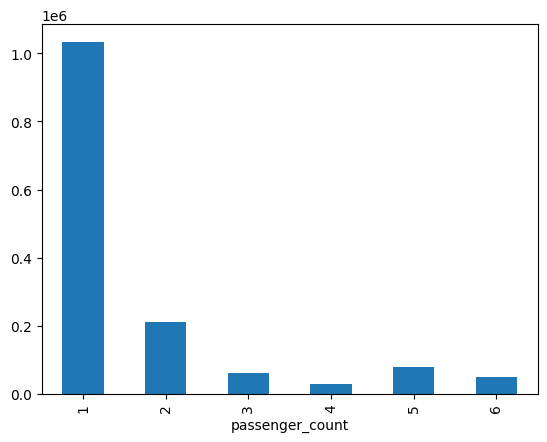

In [11]:
taxi_df['passenger_count'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='passenger_count'>

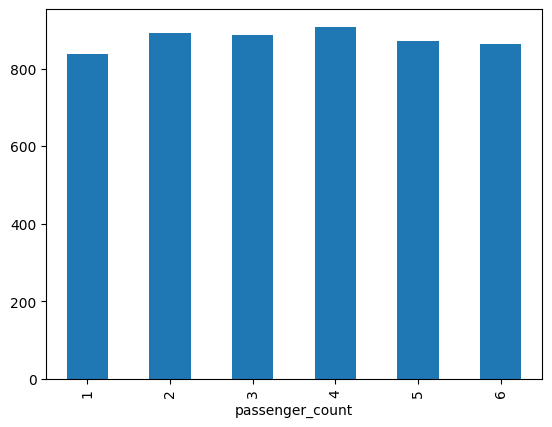

In [12]:
taxi_df.groupby('passenger_count')['trip_duration'].mean().plot(kind='bar')

- Passenger count = 0 has the highest average trip duration, which is not plausible, indicating likely data entry or logging errors

- Passenger count = 1 dominates at all hours
- Group trips (2–4 passengers) are more frequent in the evening and late night

##  pickup_longitude, pickup_latitude & dropoff_longitude, dropoff_latitude

In [13]:
print(taxi_df[gb.cols].describe())

       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude
count      1.458644e+06     1.458644e+06       1.458644e+06      1.458644e+06
mean      -7.397341e+01     4.075093e+01      -7.397310e+01      4.075180e+01
std        3.815748e-02     2.808493e-02       3.433933e-02      3.211049e-02
min       -7.405000e+01     4.059000e+01      -7.405000e+01      4.059000e+01
25%       -7.399187e+01     4.073735e+01      -7.399133e+01      4.073588e+01
50%       -7.398174e+01     4.075410e+01      -7.397975e+01      4.075452e+01
75%       -7.396733e+01     4.076836e+01      -7.396301e+01      4.076981e+01
max       -7.373000e+01     4.090000e+01      -7.373000e+01      4.090000e+01


- Some trip coordinates lie outside NYC bounds
- Some points lie far outside the visible city bounds — likely due to GPS glitches or data corruption.

## Geographic distribution

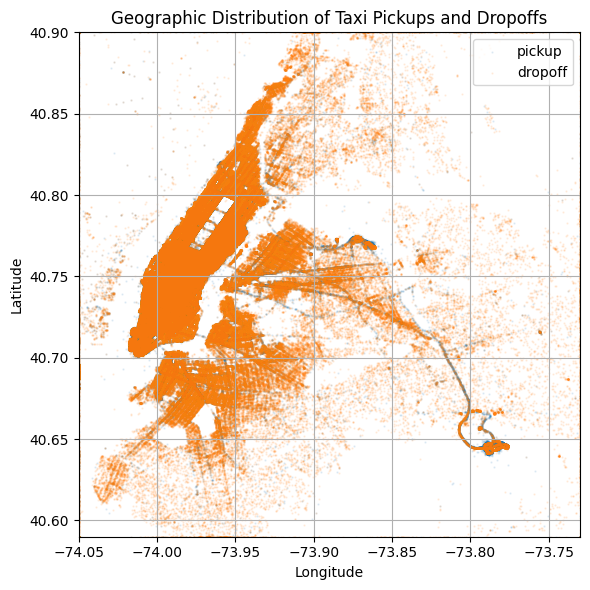

In [14]:
# Scatterplot of pickup and dropoff locations
plt.figure(figsize=(6, 6))
plt.scatter(taxi_df['pickup_longitude'], taxi_df['pickup_latitude'], s=0.5, alpha=0.1,
            label='pickup')
plt.scatter(taxi_df['dropoff_longitude'], taxi_df['dropoff_latitude'], s=0.5, alpha=0.1,
            label='dropoff')
plt.xlim(gb.min_lon, gb.max_lon)
plt.ylim(gb.min_lat, gb.max_lat)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper right')
plt.title("Geographic Distribution of Taxi Pickups and Dropoffs")
plt.grid(True)
plt.tight_layout()
plt.show()

- Most pickups and dropoffs are located within the NYC area (Manhattan, Brooklyn, Queens).
- Clear density clusters appear around Midtown and Downtown Manhattan.

##  store_and_fwd_flag

In [15]:
print(taxi_df['store_and_fwd_flag'].value_counts(dropna=False))

store_and_fwd_flag
N    1450599
Y       8045
Name: count, dtype: int64


- store_and_fwd_flag = 'Y' is rare and likely not predictive on its own

##  trip_duration

In [16]:
taxi_df['trip_duration'].describe()

count    1.458644e+06
mean     8.514188e+02
std      7.590682e+02
min      6.000000e+01
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      1.080000e+04
Name: trip_duration, dtype: float64

<Axes: ylabel='Frequency'>

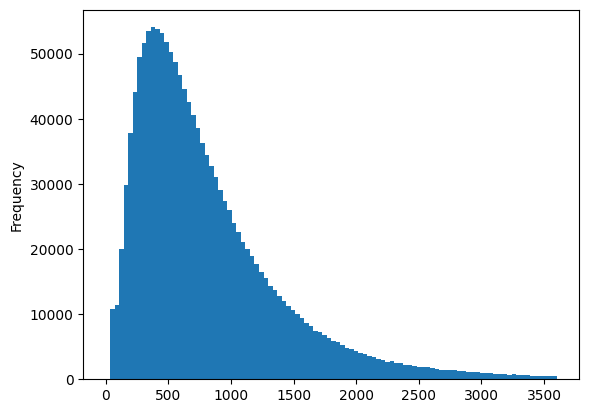

In [17]:
taxi_df['trip_duration'].plot.hist(bins=100, range=(0, 3600))  # bis 1 Stunde

- Several trips have a duration longer than 2 hours, which is highly unlikely for intra-city NYC taxi rides. A few trips are also shorter than 1 minute, which may indicate errors or missing data.

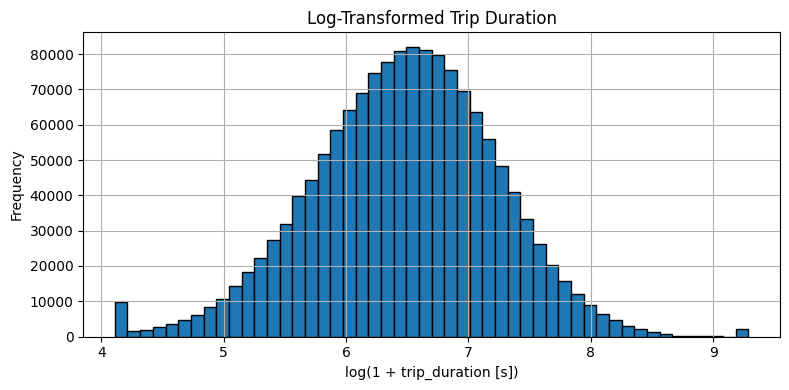

In [18]:
plt.figure(figsize=(8, 4))
plt.hist(taxi_df['trip_duration_log'], bins=50, edgecolor='black')
plt.title("Log-Transformed Trip Duration")
plt.xlabel("log(1 + trip_duration [s])")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

## distance feature (Haversine)

<Axes: xlabel='hav_dist_km', ylabel='trip_duration_log'>

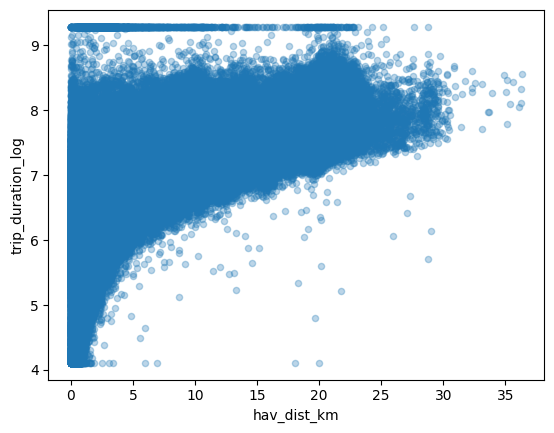

In [19]:
taxi_df.plot.scatter(x='hav_dist_km', y='trip_duration_log', alpha=0.3)

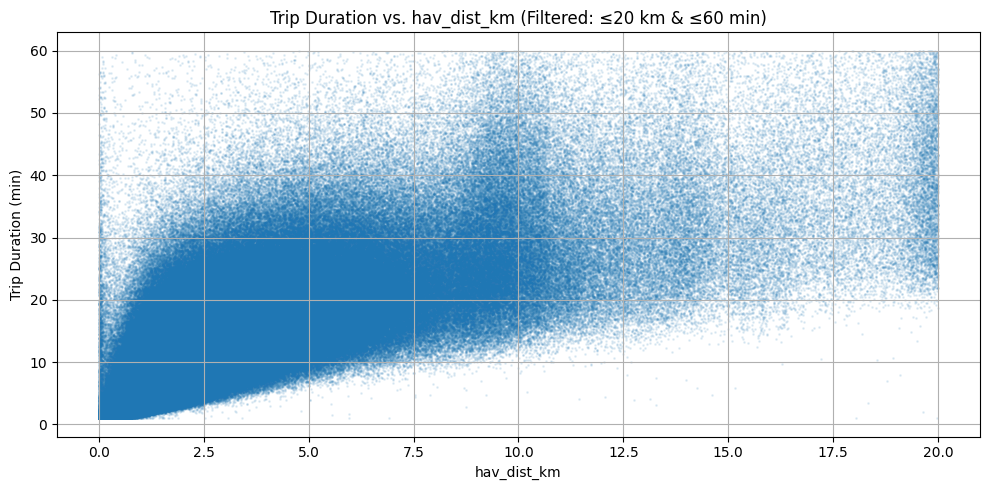

In [20]:
# Filter for clearer visualization
filtered_data = taxi_df[
  (taxi_df['route_distance_km'] <= 20) &
  (taxi_df['hav_dist_km'] > 0.0) &
  (taxi_df['trip_duration_min'] <= 60) &
  (taxi_df['trip_duration_min'] > 0)
  ]

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(filtered_data['hav_dist_km'], filtered_data['trip_duration_min'], alpha=0.1, s=1)
plt.xlabel("hav_dist_km")
plt.ylabel("Trip Duration (min)")
plt.title("Trip Duration vs. hav_dist_km (Filtered: ≤20 km & ≤60 min)")
plt.grid(True)
plt.tight_layout()
plt.show()

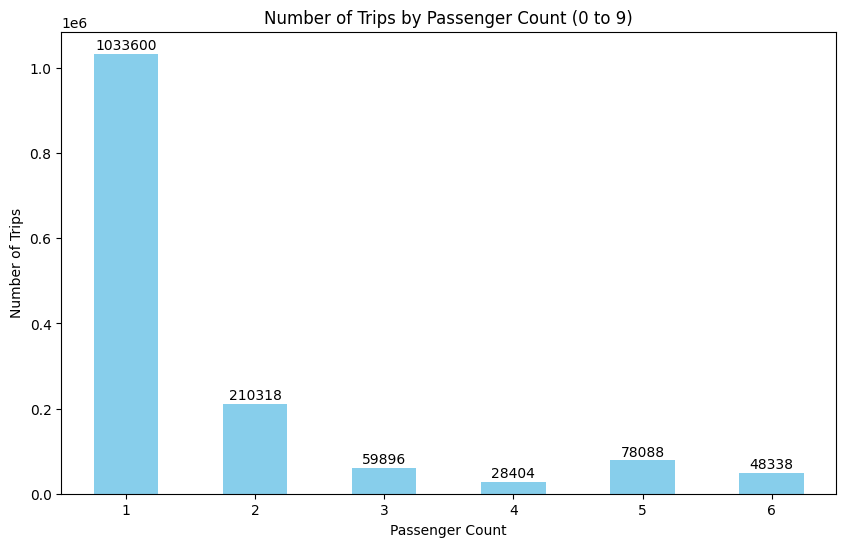

In [21]:
# Count the number of trips for each passenger count
passenger_count_distribution = taxi_df['passenger_count'].value_counts().sort_index()

# Filter for passenger counts from 0 to 9
passenger_count_distribution = passenger_count_distribution.loc[0:9]

# Plot the distribution
plt.figure(figsize=(10, 6))
passenger_count_distribution.plot(kind='bar', color='skyblue')
plt.title('Number of Trips by Passenger Count (0 to 9)')
plt.xlabel('Passenger Count')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
# Annotate the bars with the number of trips
for index, value in enumerate(passenger_count_distribution):
    plt.text(index, value + max(passenger_count_distribution) * 0.01, str(value), ha='center', fontsize=10)
plt.show()

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train = taxi_df
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_day'] = train['pickup_datetime'].dt.dayofweek
train['pickup_month'] = train['pickup_datetime'].dt.month
train['day_of_year'] = train['pickup_datetime'].dt.dayofyear

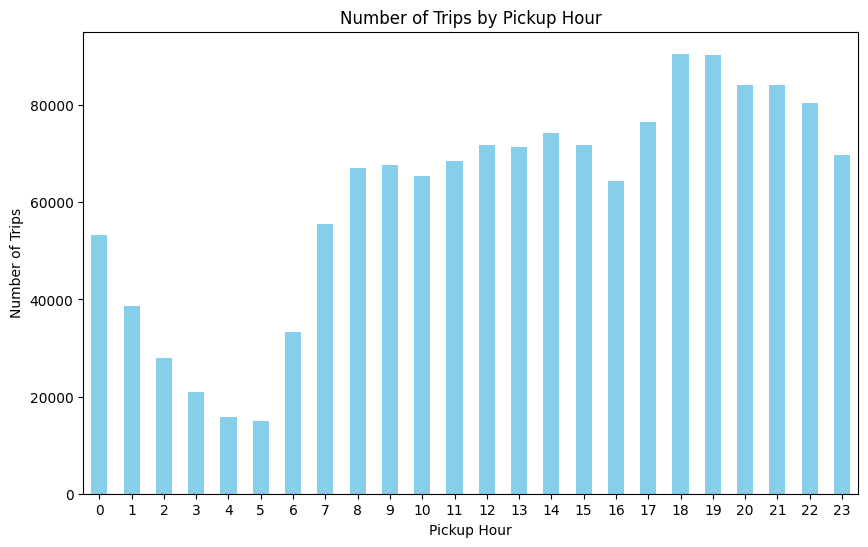

In [24]:
# Calculate the number of trips for each pickup hour
pickup_hour_counts = train['pickup_hour'].value_counts().sort_index()

# Plot the distribution of pickup_hour
plt.figure(figsize=(10, 6))
pickup_hour_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Trips by Pickup Hour')
plt.xlabel('Pickup Hour')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
plt.show()

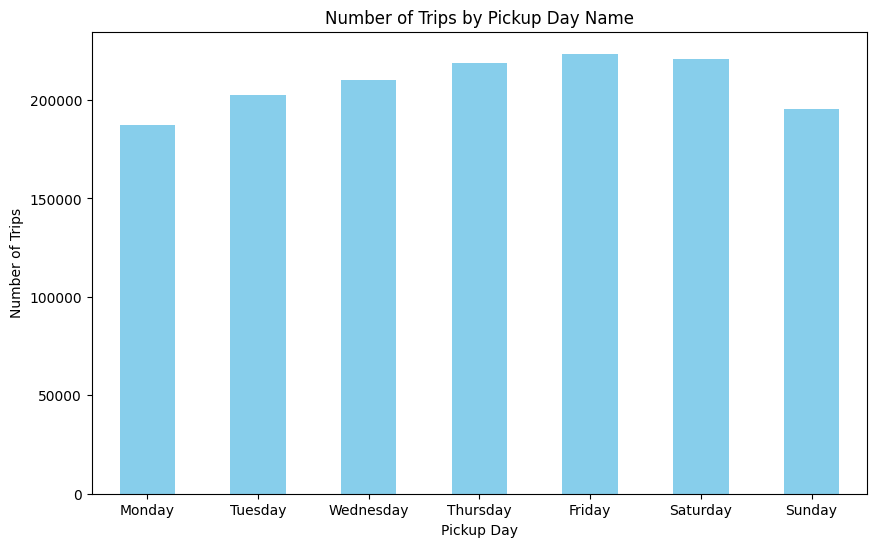

In [25]:
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train['pickup_day_name'] = train['pickup_day'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
    3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})
pickup_day_counts = train['pickup_day_name'].value_counts().reindex(weekday_labels)

plt.figure(figsize=(10, 6))
pickup_day_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Trips by Pickup Day Name')
plt.xlabel('Pickup Day')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
plt.show()

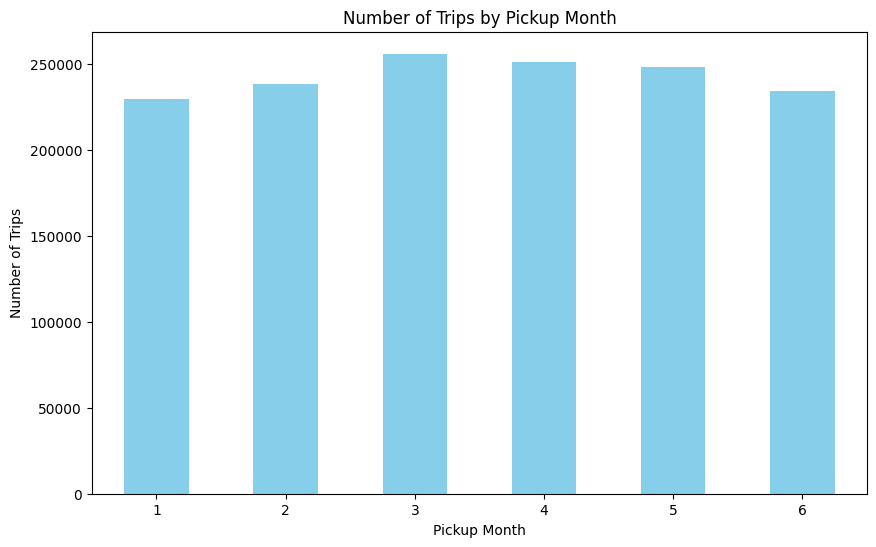

In [29]:
pickup_hour_counts = train['pickup_month'].value_counts().sort_index()

month_labels = ['January', 'February', 'March', 'April', 'May', 'June']
train['pickup_month_name'] = train['pickup_month'].map({
    1: 'January', 2: 'February',
    3: 'March', 4: 'April', 5: 'May', 6: 'June'
})
pickup_day_counts = train['pickup_month_name'] # .value_counts().reindex(weekday_labels)

# Plot the distribution of pickup_month
plt.figure(figsize=(10, 6))
pickup_hour_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Trips by Pickup Month')
plt.xlabel('Pickup Month')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
plt.show()

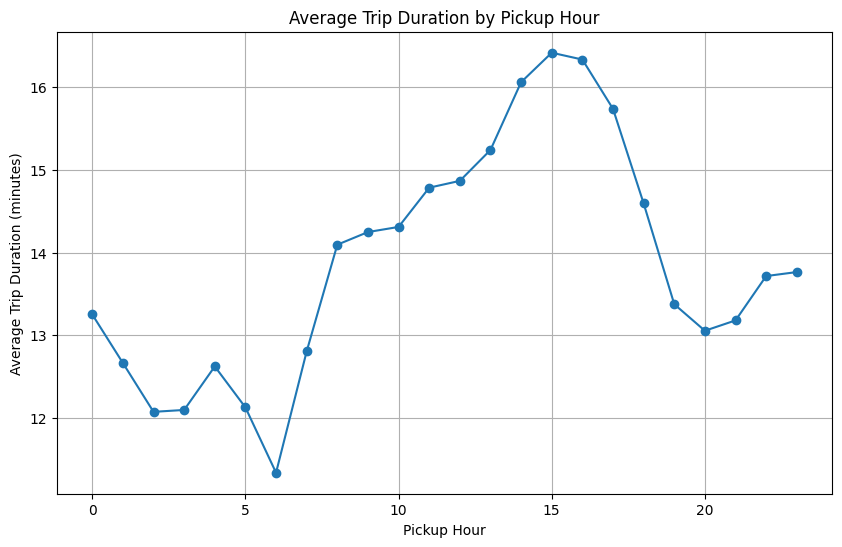

In [30]:
hourly_avg = train.groupby('pickup_hour')['trip_duration_min'].mean()
plt.figure(figsize=(10, 6))
plt.plot(hourly_avg.index, hourly_avg, marker='o', linestyle='-')
plt.title('Average Trip Duration by Pickup Hour')
plt.xlabel('Pickup Hour')
plt.ylabel('Average Trip Duration (minutes)')
plt.grid(True)
plt.show()


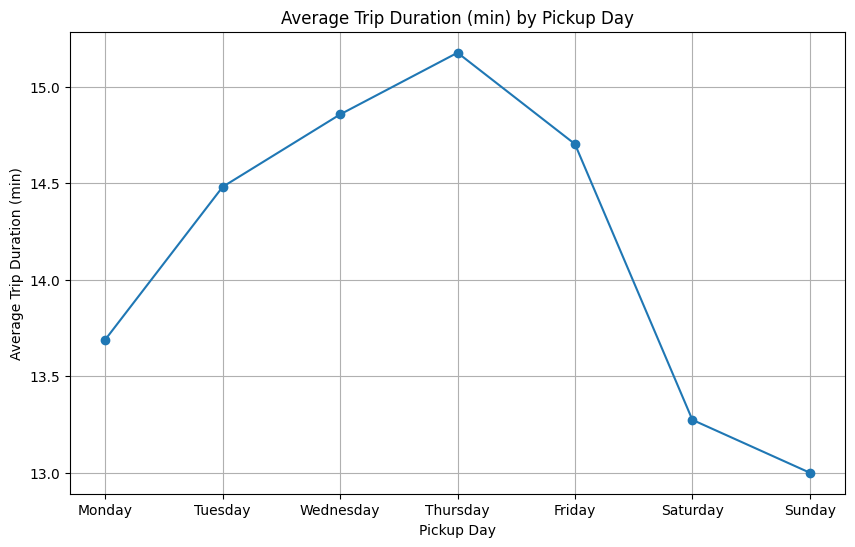

In [31]:
avg_by_day = train.groupby('pickup_day_name')['trip_duration_min'].mean()

avg_by_day = avg_by_day.reindex(weekday_labels)
plt.figure(figsize=(10,6))
plt.plot(avg_by_day.index, avg_by_day, marker='o', linestyle='-')
plt.title('Average Trip Duration (min) by Pickup Day')
plt.xlabel('Pickup Day')
plt.ylabel('Average Trip Duration (min)')
plt.grid(True)
plt.show()


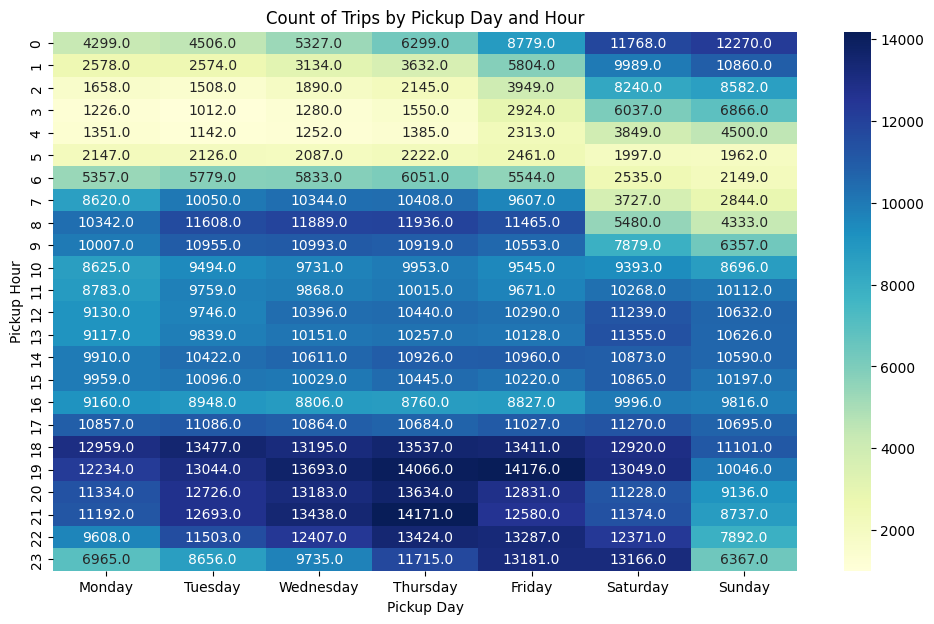

In [33]:
import seaborn as sns

hourly_avg = train.groupby(['pickup_day_name', 'pickup_hour'])['trip_duration_min'].count()
# Pivot the series so that rows represent pickup_hour and columns represent pickup_day_name
heatmap_data = hourly_avg.unstack(level=0)

# Optionally, reorder the columns based on weekday_labels if defined
if 'weekday_labels' in globals():
    heatmap_data = heatmap_data[weekday_labels]

plt.figure(figsize=(12, 7))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Count of Trips by Pickup Day and Hour")
plt.xlabel("Pickup Day")
plt.ylabel("Pickup Hour")
plt.show()


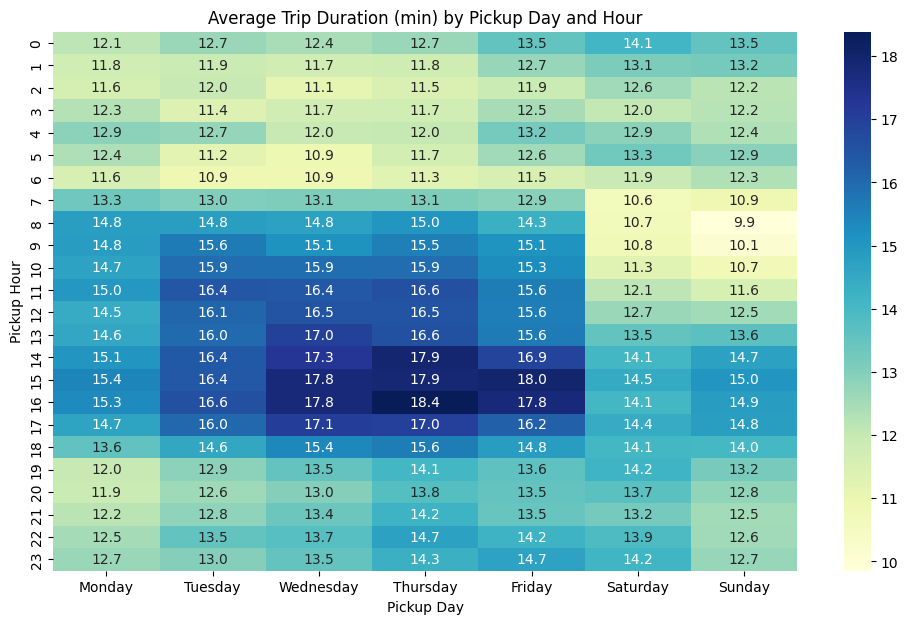

In [32]:
import seaborn as sns

hourly_avg = train.groupby(['pickup_day_name', 'pickup_hour'])['trip_duration_min'].mean()
# Pivot the series so that rows represent pickup_hour and columns represent pickup_day_name
heatmap_data = hourly_avg.unstack(level=0)

# Optionally, reorder the columns based on weekday_labels if defined
if 'weekday_labels' in globals():
    heatmap_data = heatmap_data[weekday_labels]

plt.figure(figsize=(12, 7))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Average Trip Duration (min) by Pickup Day and Hour")
plt.xlabel("Pickup Day")
plt.ylabel("Pickup Hour")
plt.show()